##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
a,b = fashion_mnist.load_data()

In [ ]:
len(a)

2

In [ ]:
len(b)

2

In [ ]:
x_train.min()

0.0

In [ ]:
x_train.max()

1.0

## First example: Basic autoencoder
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 4
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
64 / (28*28)

0.08163265306122448

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
from tensorflow.keras.callbacks import Callback

class MyCustomCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Training has started!")

    def on_epoch_end(self, epoch, logs=None):
        print("CALLBACK: show_reconstructed_images()")
        encoded_imgs = autoencoder.encoder(x_test).numpy()
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
          # display original
          ax = plt.subplot(2, n, i + 1)
          plt.imshow(x_test[i])
          plt.title("original")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

          # display reconstruction
          ax = plt.subplot(2, n, i + 1 + n)
          plt.imshow(decoded_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
        plt.show()

    def on_train_end(self, logs=None):
        print("Training has ended!")

Training has started!
Epoch 1/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1559CALLBACK: show_reconstructed_images()


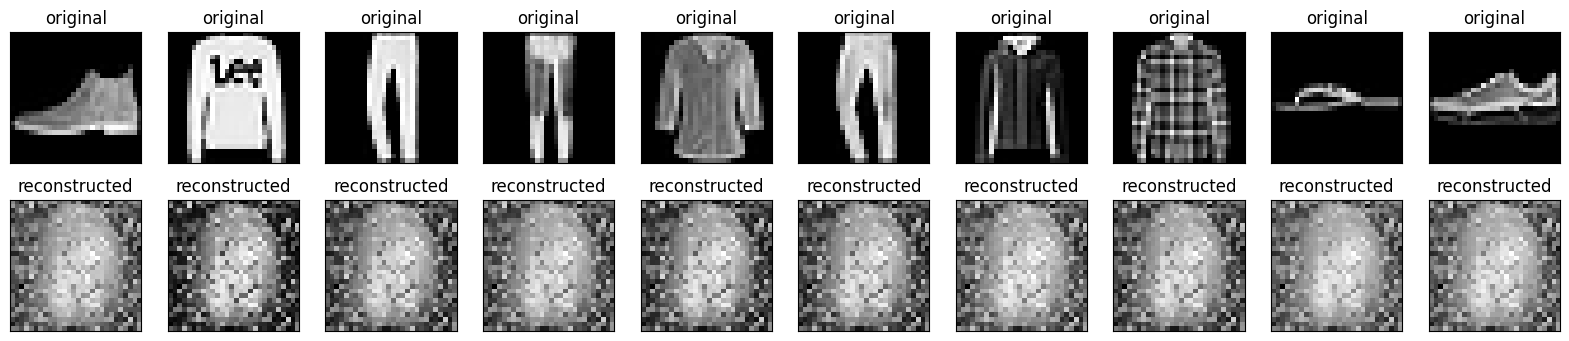

30/30 [==============================] - 2s 55ms/step - loss: 0.1543 - val_loss: 0.1269
Epoch 2/20
29/30 [============================>.] - ETA: 0s - loss: 0.1083CALLBACK: show_reconstructed_images()


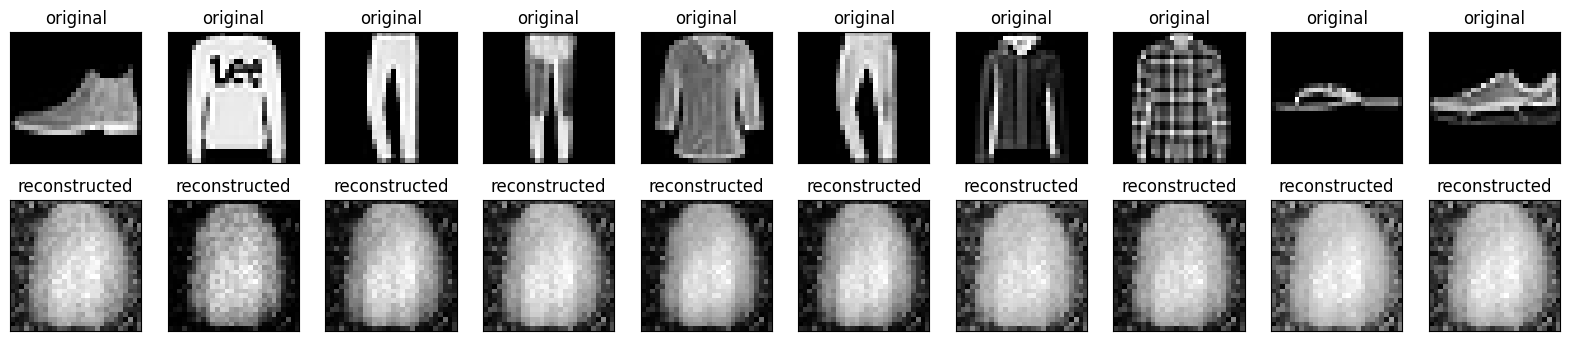

30/30 [==============================] - 1s 49ms/step - loss: 0.1079 - val_loss: 0.0950
Epoch 3/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0909CALLBACK: show_reconstructed_images()


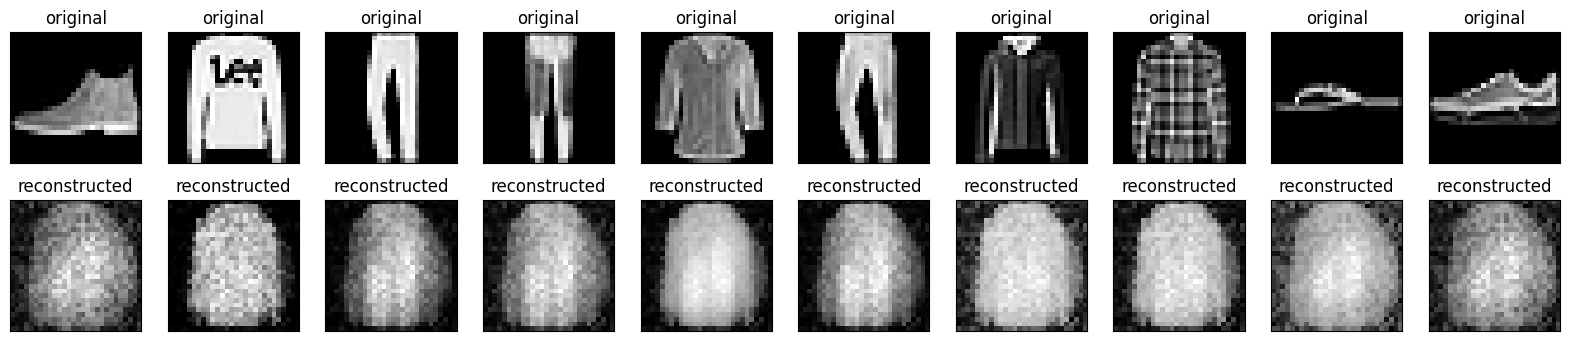

30/30 [==============================] - 2s 79ms/step - loss: 0.0904 - val_loss: 0.0842
Epoch 4/20
26/30 [=========================>....] - ETA: 0s - loss: 0.0791CALLBACK: show_reconstructed_images()


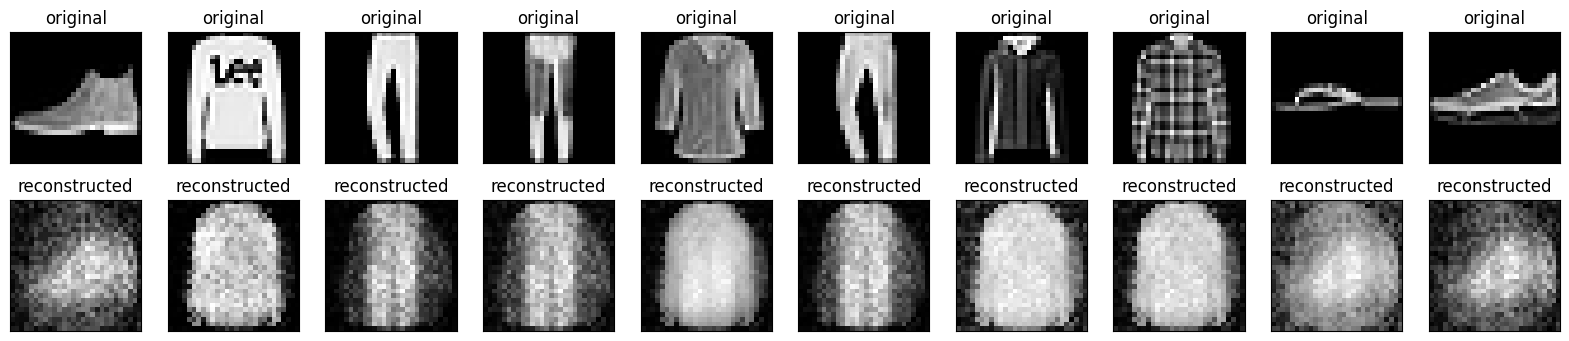

30/30 [==============================] - 2s 65ms/step - loss: 0.0782 - val_loss: 0.0711
Epoch 5/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0672CALLBACK: show_reconstructed_images()


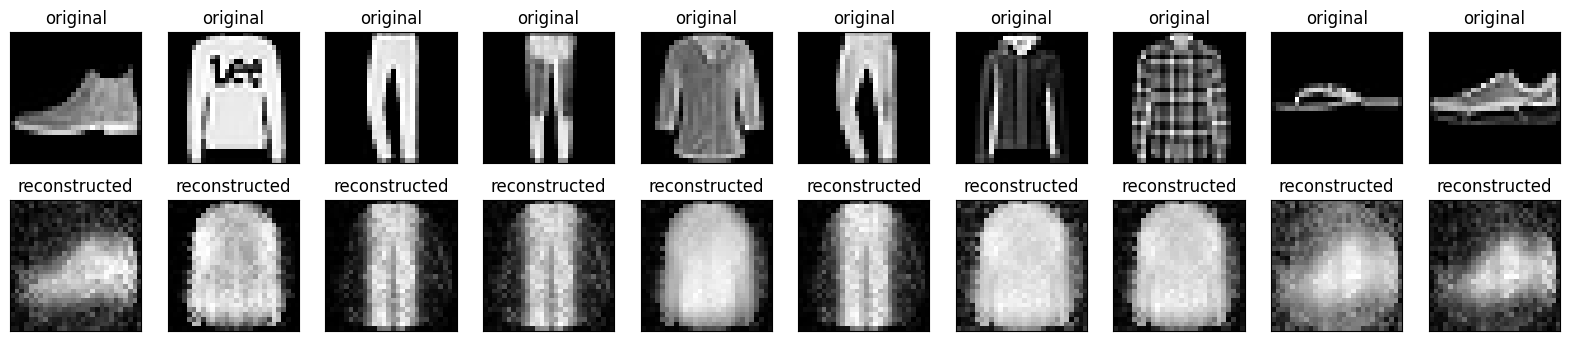

30/30 [==============================] - 2s 54ms/step - loss: 0.0669 - val_loss: 0.0626
Epoch 6/20
28/30 [===========================>..] - ETA: 0s - loss: 0.0610CALLBACK: show_reconstructed_images()


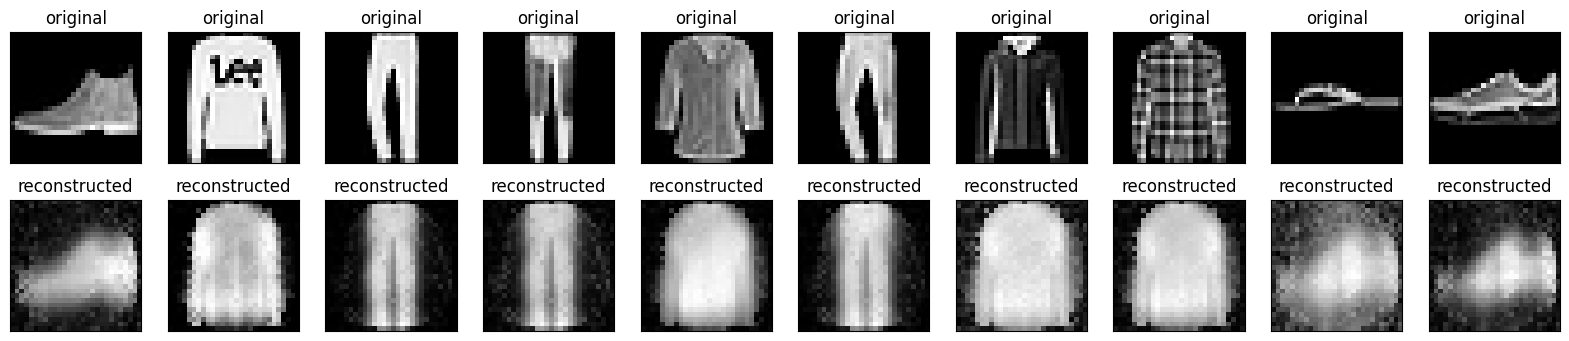

30/30 [==============================] - 1s 48ms/step - loss: 0.0609 - val_loss: 0.0588
Epoch 7/20
26/30 [=========================>....] - ETA: 0s - loss: 0.0582CALLBACK: show_reconstructed_images()


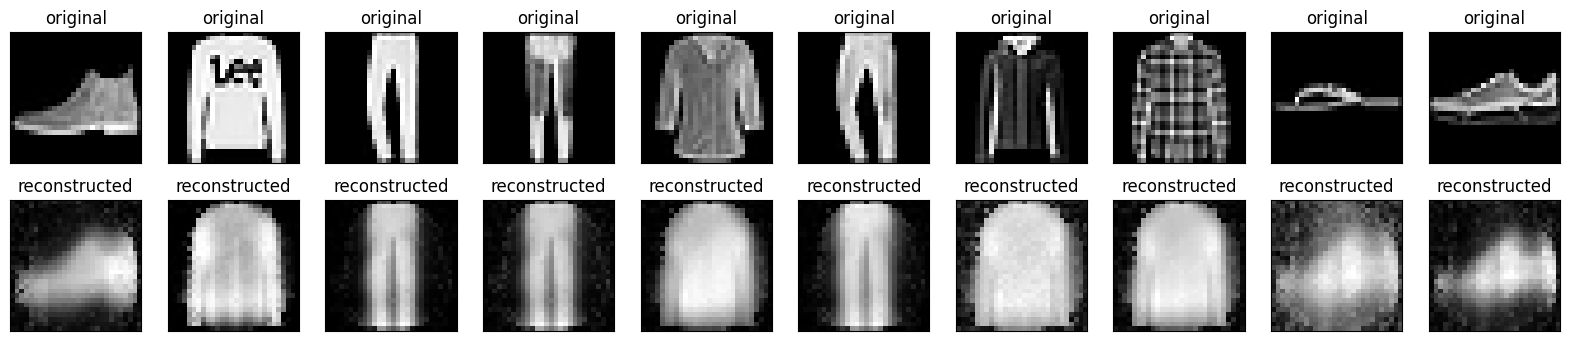

30/30 [==============================] - 2s 64ms/step - loss: 0.0580 - val_loss: 0.0566
Epoch 8/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0561CALLBACK: show_reconstructed_images()


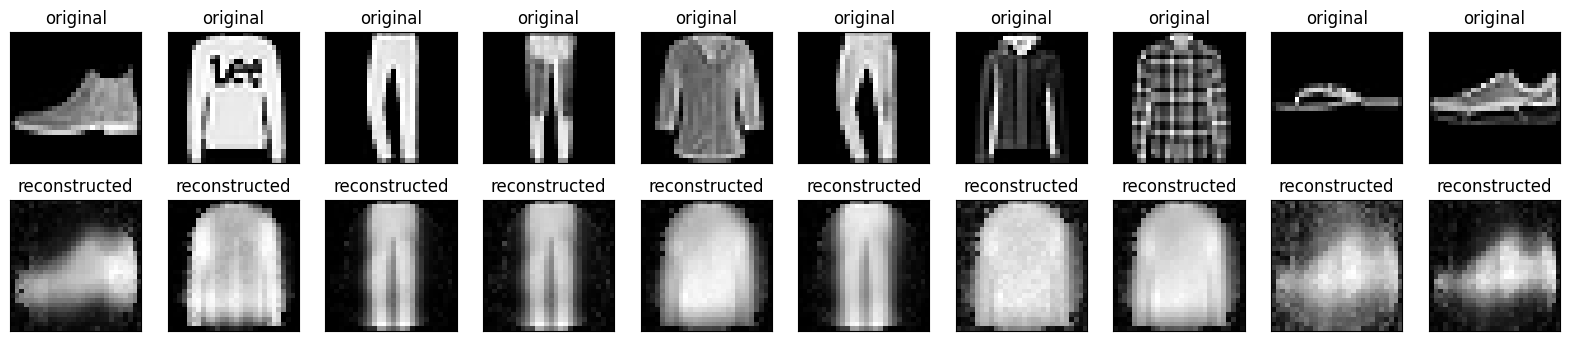

30/30 [==============================] - 2s 55ms/step - loss: 0.0560 - val_loss: 0.0548
Epoch 9/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0543CALLBACK: show_reconstructed_images()


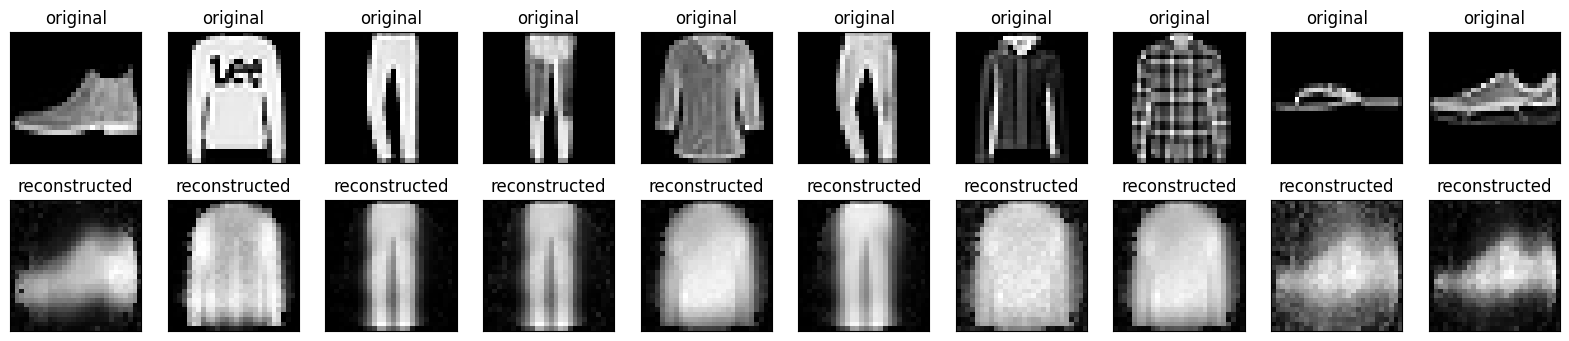

30/30 [==============================] - 2s 54ms/step - loss: 0.0542 - val_loss: 0.0530
Epoch 10/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0524CALLBACK: show_reconstructed_images()


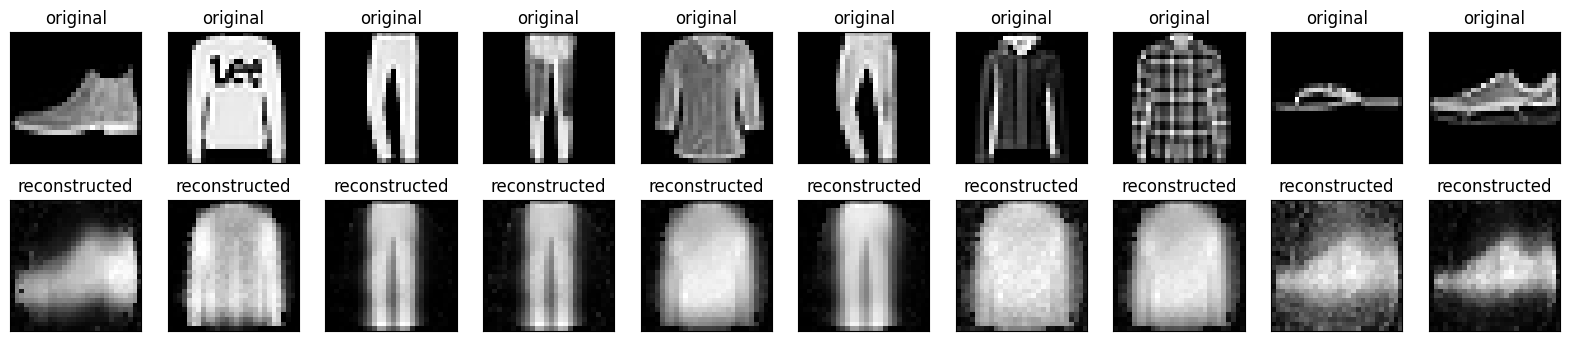

30/30 [==============================] - 2s 55ms/step - loss: 0.0523 - val_loss: 0.0511
Epoch 11/20
25/30 [========================>.....] - ETA: 0s - loss: 0.0505CALLBACK: show_reconstructed_images()


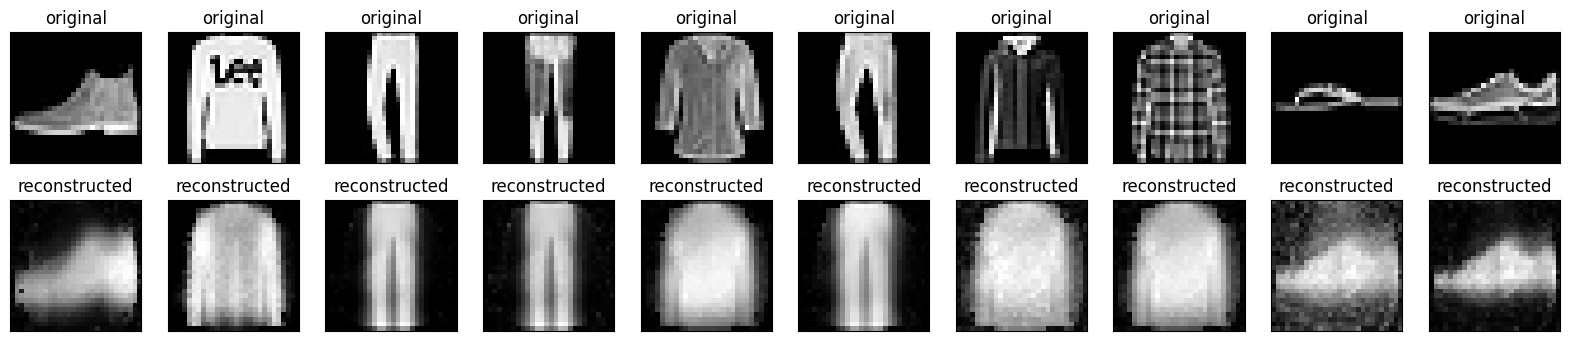

30/30 [==============================] - 3s 86ms/step - loss: 0.0504 - val_loss: 0.0495
Epoch 12/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0489CALLBACK: show_reconstructed_images()


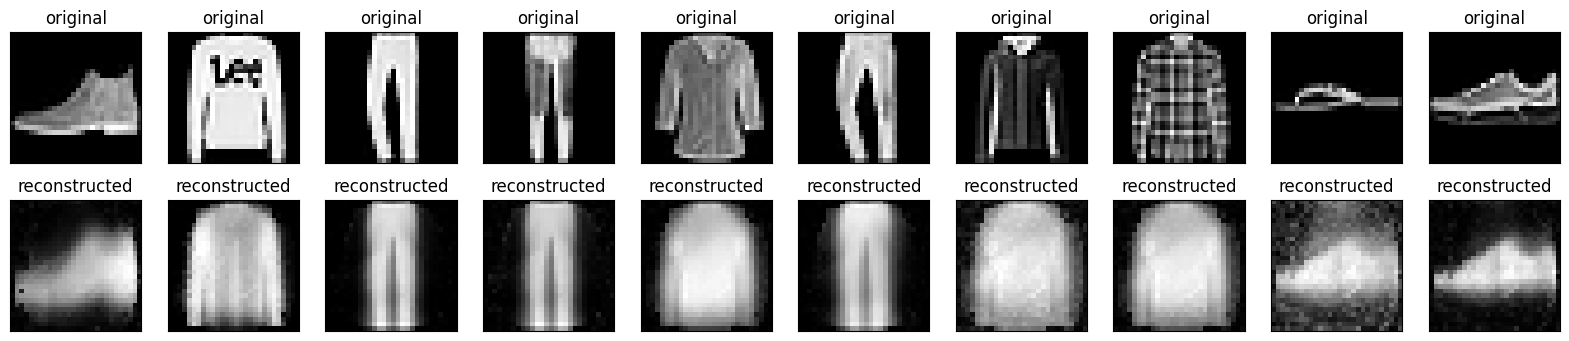

30/30 [==============================] - 2s 56ms/step - loss: 0.0489 - val_loss: 0.0481
Epoch 13/20
29/30 [============================>.] - ETA: 0s - loss: 0.0477CALLBACK: show_reconstructed_images()


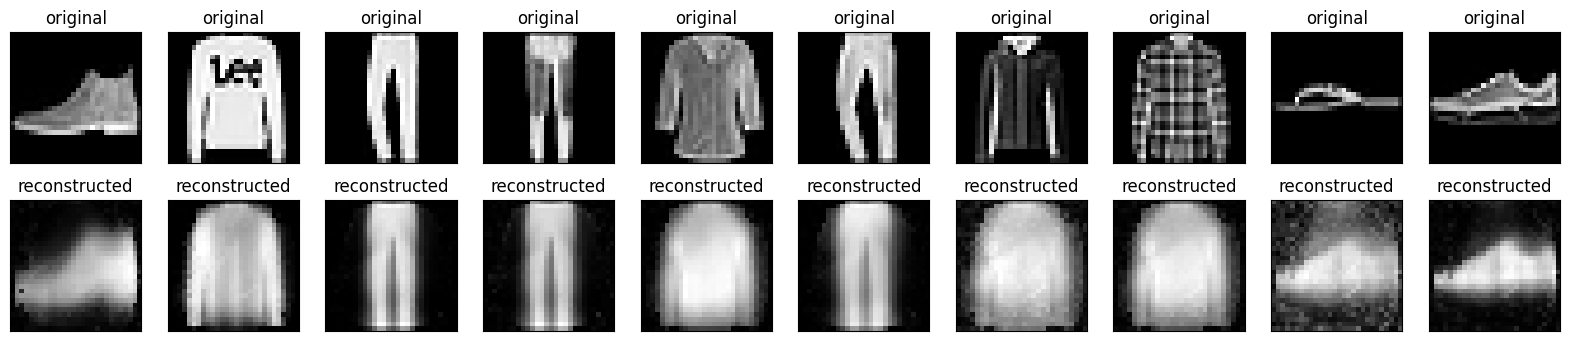

30/30 [==============================] - 2s 57ms/step - loss: 0.0477 - val_loss: 0.0471
Epoch 14/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0467CALLBACK: show_reconstructed_images()


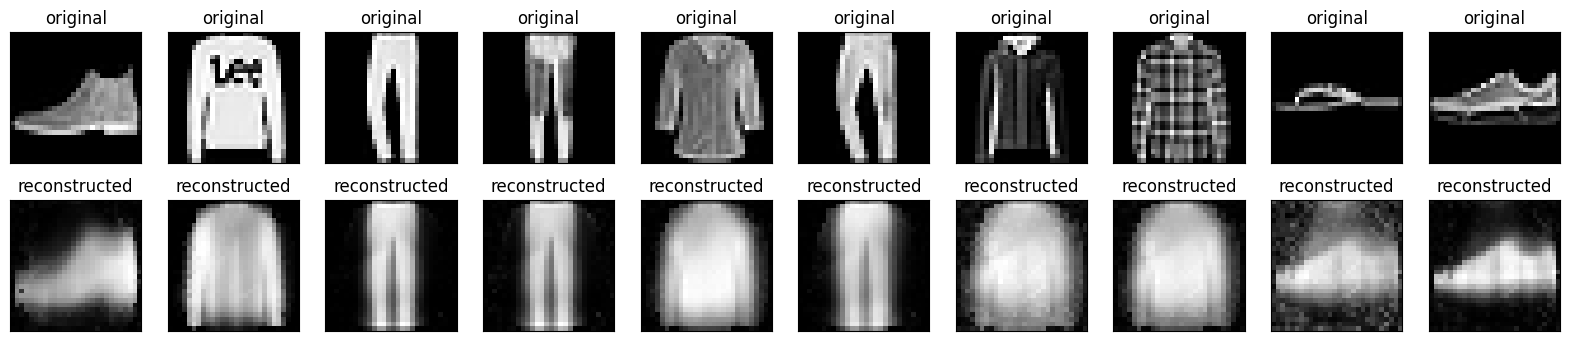

30/30 [==============================] - 2s 54ms/step - loss: 0.0467 - val_loss: 0.0462
Epoch 15/20
26/30 [=========================>....] - ETA: 0s - loss: 0.0460CALLBACK: show_reconstructed_images()


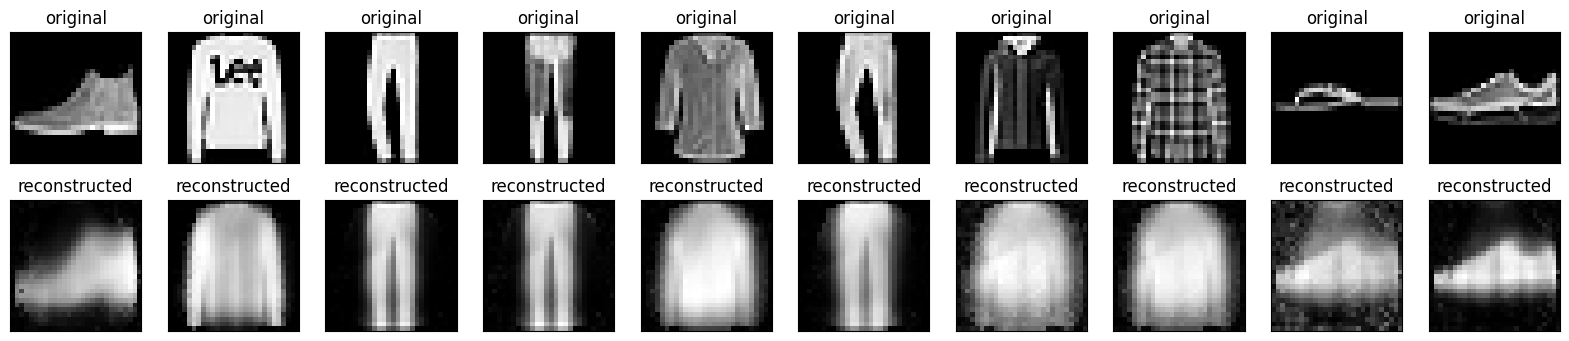

30/30 [==============================] - 2s 66ms/step - loss: 0.0460 - val_loss: 0.0455
Epoch 16/20
30/30 [==============================] - ETA: 0s - loss: 0.0453CALLBACK: show_reconstructed_images()


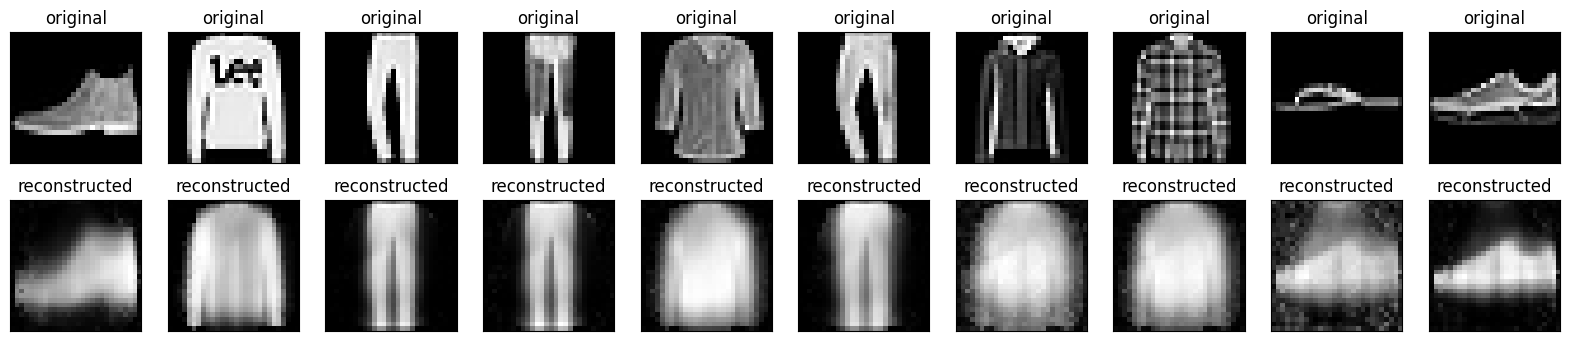

30/30 [==============================] - 2s 55ms/step - loss: 0.0453 - val_loss: 0.0449
Epoch 17/20
25/30 [========================>.....] - ETA: 0s - loss: 0.0447CALLBACK: show_reconstructed_images()


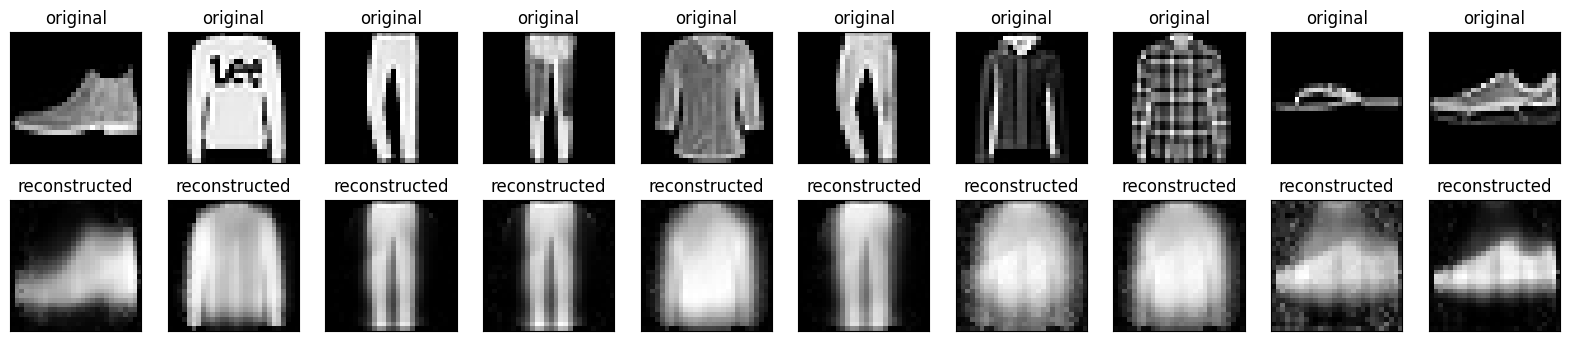

30/30 [==============================] - 3s 87ms/step - loss: 0.0447 - val_loss: 0.0443
Epoch 18/20
29/30 [============================>.] - ETA: 0s - loss: 0.0441CALLBACK: show_reconstructed_images()


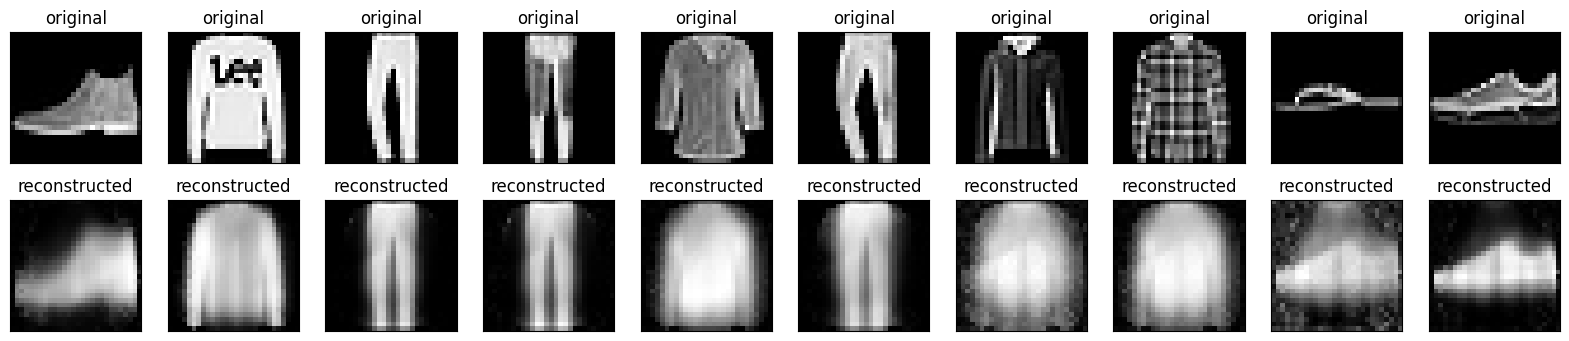

30/30 [==============================] - 4s 149ms/step - loss: 0.0441 - val_loss: 0.0438
Epoch 19/20
26/30 [=========================>....] - ETA: 0s - loss: 0.0436CALLBACK: show_reconstructed_images()


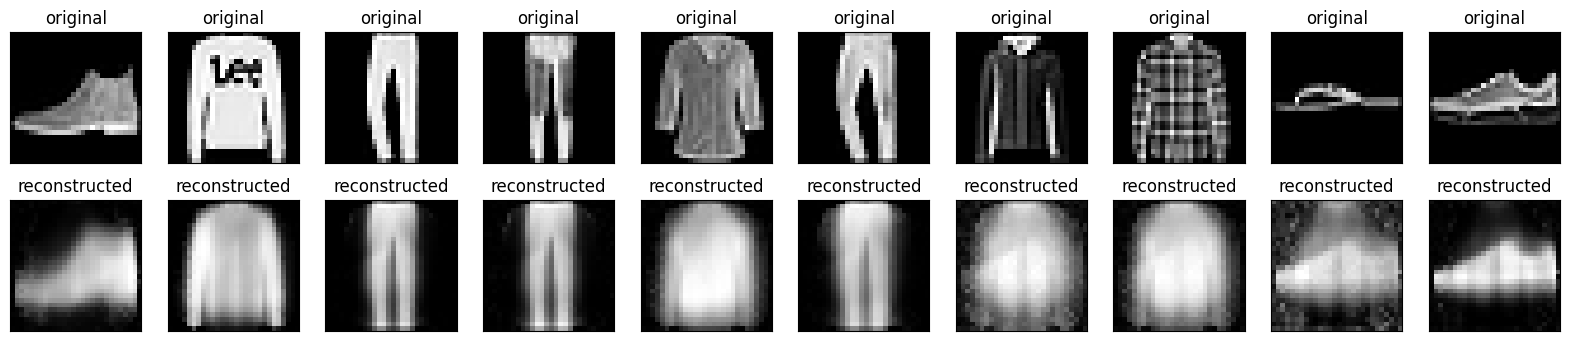

30/30 [==============================] - 2s 62ms/step - loss: 0.0436 - val_loss: 0.0433
Epoch 20/20
24/30 [=======================>......] - ETA: 0s - loss: 0.0432CALLBACK: show_reconstructed_images()


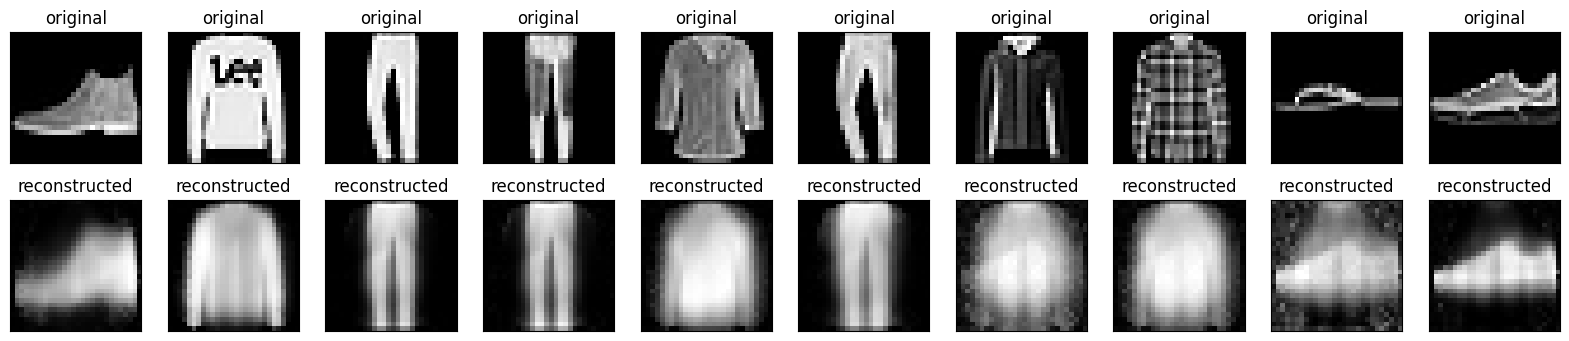

30/30 [==============================] - 1s 49ms/step - loss: 0.0432 - val_loss: 0.0429
Training has ended!


In [ ]:
my_callback = MyCustomCallback()

h = autoencoder.fit(x_train, x_train,
                    epochs=20,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[my_callback],
                    steps_per_epoch=30)

In [ ]:
64000*200*200*4

10240000000

In [ ]:
h.history

{'loss': [0.04980940371751785,
  0.03557318076491356,
  0.03361287713050842,
  0.03313839063048363,
  0.032972268760204315,
  0.03288620337843895,
  0.03281445801258087,
  0.03276273235678673,
  0.03273157402873039,
  0.03270408883690834],
 'val_loss': [0.03757697716355324,
  0.034060943871736526,
  0.033359184861183167,
  0.032946981489658356,
  0.032824985682964325,
  0.032717909663915634,
  0.03268315643072128,
  0.03266198933124542,
  0.03261851519346237,
  0.032656680792570114]}

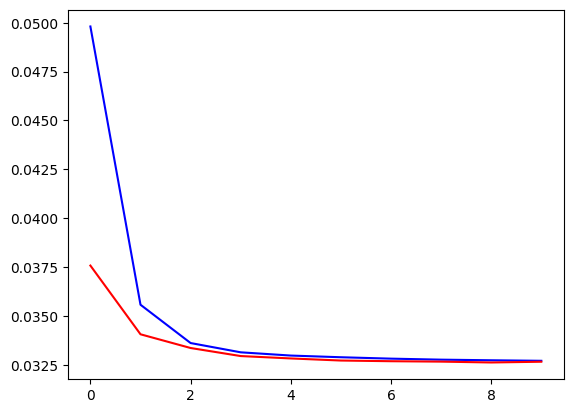

In [ ]:
plt.plot(h.history["loss"], color="blue")
plt.plot(h.history["val_loss"], color="red")
plt.show()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
encoded_imgs.shape

(10000, 64)

In [ ]:
decoded_imgs.shape

(10000, 28, 28)

In [ ]:
encoded_imgs[0]

array([2.4029984 , 1.2480023 , 1.260259  , 1.4982767 , 2.926291  ,
       3.536353  , 3.386579  , 2.0635197 , 0.85134506, 0.        ,
       2.2912393 , 5.957706  , 3.502889  , 4.494746  , 1.4734465 ,
       1.7319846 , 2.0177605 , 1.2978406 , 4.862102  , 1.7785306 ,
       1.9155654 , 2.161873  , 2.9963493 , 2.7902377 , 1.8833592 ,
       2.0778856 , 1.1267043 , 4.4641213 , 3.0865374 , 1.8034286 ,
       1.5443114 , 3.762147  , 3.147646  , 1.1778493 , 2.440096  ,
       2.0427501 , 3.4081602 , 2.0994542 , 1.6402988 , 1.8898764 ,
       2.4927855 , 0.4912153 , 1.9240429 , 4.79727   , 1.6676255 ,
       0.84531367, 1.5273049 , 6.579935  , 0.6499977 , 3.1546173 ,
       1.6883223 , 0.        , 1.2479943 , 3.5587606 , 2.6916485 ,
       0.91107106, 2.6445084 , 1.0788035 , 2.5476155 , 0.8106024 ,
       2.6212044 , 5.0256786 , 1.2784307 , 4.401109  ], dtype=float32)

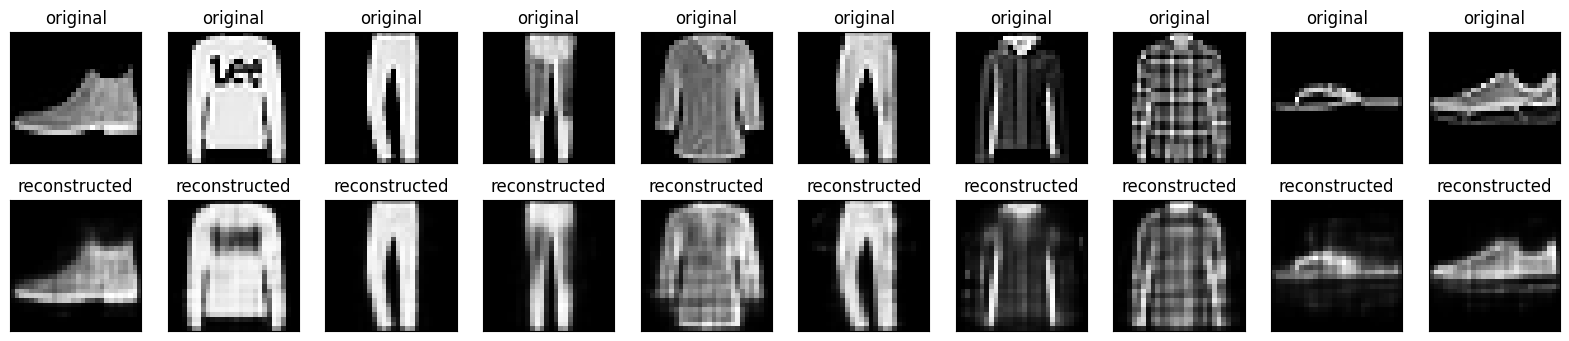

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train.dtype

dtype('uint8')

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [ ]:
zufalls_tensor = tf.random.normal(shape=x_train.shape)
zufalls_tensor.shape

TensorShape([60000, 28, 28, 1])

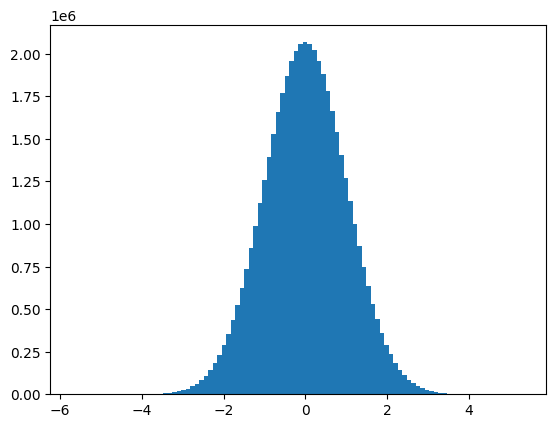

In [ ]:
plt.hist( zufalls_tensor.numpy().flatten(), bins=100 )
plt.show()

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


In [ ]:
tf.squeeze( x_test_noisy[0] ).shape

TensorShape([28, 28])

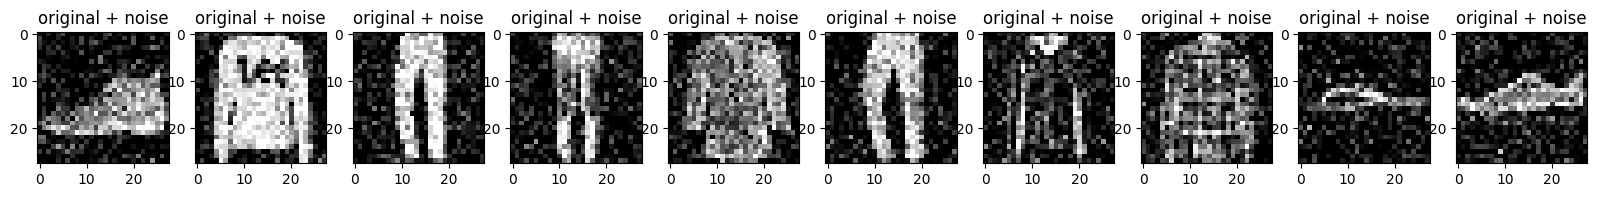

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=7,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 2/7
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 3/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 4/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 5/7
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0165 - val_loss: 0.0153
Epoch 6/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 7/7
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0165 - val_loss: 0.0155


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
print(x_test_noisy.shape,
      "--ENC--> LAT DIM:",
      encoded_imgs.shape ,
      "--DEC-->",
      decoded_imgs.shape)

(10000, 28, 28, 1) --ENC--> LAT DIM: (10000, 7, 7, 8) --DEC--> (10000, 28, 28, 1)


In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
encoded_imgs.shape

(10000, 7, 7, 8)

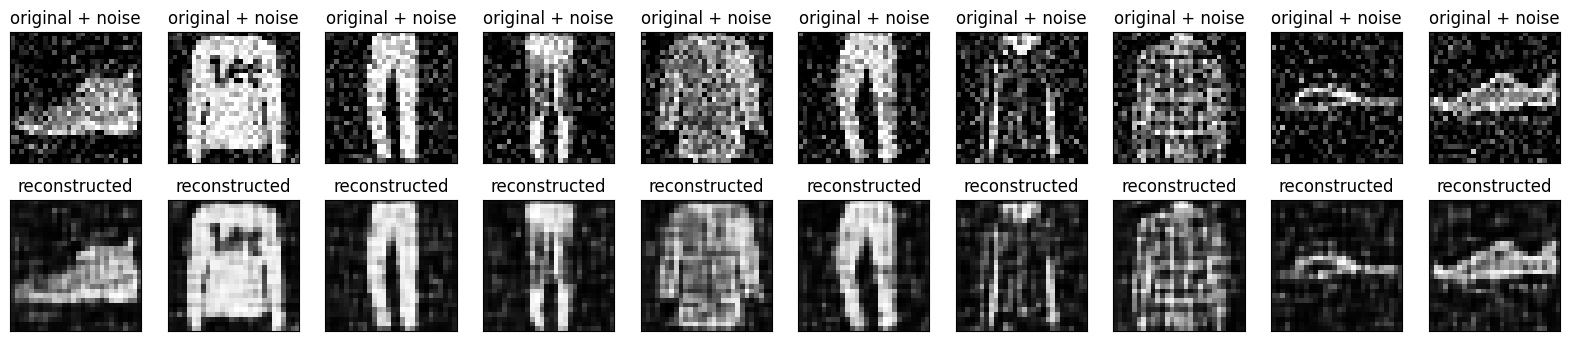

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head(7)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
5,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134,1.0
6,-0.297161,-2.766635,-4.102185,-4.589669,-4.219357,-3.650443,-2.300518,-1.293917,-1.065658,-0.490520,...,0.581779,0.684406,0.911651,0.979483,1.053458,0.974787,1.110407,1.288165,-0.823386,1.0


In [ ]:
dataframe.values.shape

(4998, 141)

In [ ]:
dataframe.values[:,-1]

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
train_data.shape

TensorShape([3998, 140])

In [ ]:
test_data.shape

TensorShape([1000, 140])

In [ ]:
data.shape

(4998, 140)

Normalize the data to `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_data.numpy().min()

0.0

In [ ]:
train_data.numpy().max()

1.0

In [ ]:
train_data[~train_labels.astype(bool)]

<tf.Tensor: shape=(1639, 140), dtype=float32, numpy=
array([[0.4304001 , 0.35345322, 0.30342638, ..., 0.30506894, 0.262255  ,
        0.2502011 ],
       [0.4494794 , 0.37906834, 0.3202905 , ..., 0.31546655, 0.39611116,
        0.46317974],
       [0.49198422, 0.4355403 , 0.3698029 , ..., 0.5260356 , 0.52524984,
        0.5278486 ],
       ...,
       [0.43457043, 0.362154  , 0.34958026, ..., 0.3179064 , 0.3426891 ,
        0.49215436],
       [0.4814947 , 0.4255184 , 0.38368973, ..., 0.29031053, 0.3311408 ,
        0.4467481 ],
       [0.4276824 , 0.3507402 , 0.31587753, ..., 0.3177887 , 0.33242297,
        0.419218  ]], dtype=float32)>

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

In [ ]:
normal_train_data[0]

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.57030463, 0.46561658, 0.29058117, 0.17791584, 0.09538919,
       0.08467858, 0.20195104, 0.3163002 , 0.33732033, 0.41424882,
       0.47070596, 0.4691905 , 0.47767755, 0.4800409 , 0.47027245,
       0.4729927 , 0.47917148, 0.48027468, 0.4692887 , 0.46106863,
       0.46148038, 0.4465829 , 0.45325327, 0.45610094, 0.4489618 ,
       0.4432532 , 0.43402174, 0.44307235, 0.43250525, 0.43014902,
       0.41454658, 0.4120653 , 0.4042028 , 0.41054544, 0.4082913 ,
       0.40342993, 0.39648476, 0.39332044, 0.39158815, 0.39603877,
       0.40746954, 0.4053118 , 0.4173488 , 0.41624558, 0.42334118,
       0.44590637, 0.4455184 , 0.44474098, 0.44404328, 0.45673218,
       0.45217463, 0.4532504 , 0.46082932, 0.46695936, 0.46631944,
       0.4743283 , 0.4629709 , 0.4738895 , 0.46788898, 0.4673448 ,
       0.48026675, 0.4843984 , 0.48574668, 0.48985568, 0.49317348,
       0.4883041 , 0.49913937, 0.5057092 , 0.5078241 , 0.51323026,
       0.52119

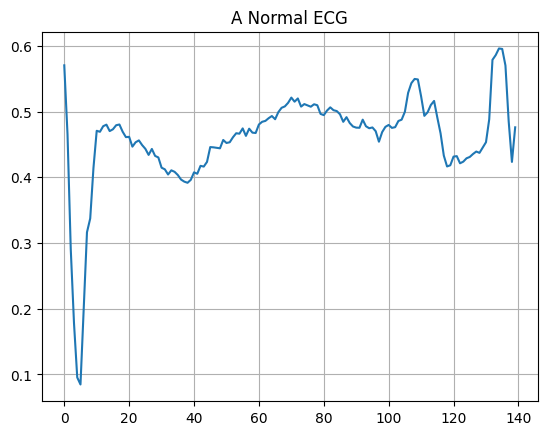

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

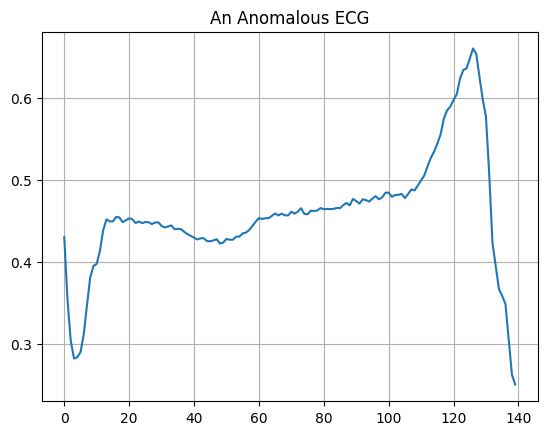

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 45ms/step - loss: 0.0581 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0562 - val_loss: 0.0521
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0538 - val_loss: 0.0505
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0504 - val_loss: 0.0491
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0466 - val_loss: 0.0468
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0425 - val_loss: 0.0448
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0388 - val_loss: 0.0430
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0356 - val_loss: 0.0417
Epoch 9/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0330 - val_loss: 0.0402
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0392
Epoch 11/20
5/5 [============

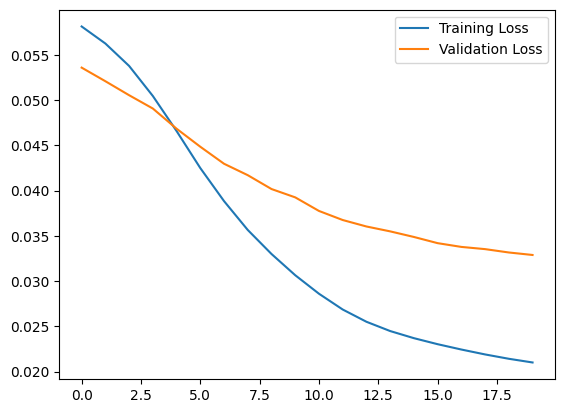

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

In [ ]:
normal_test_data.shape

TensorShape([560, 140])

In [ ]:
encoded_data.shape

(560, 8)

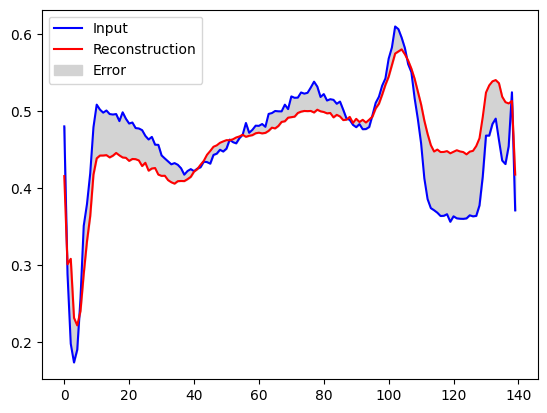

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightgray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

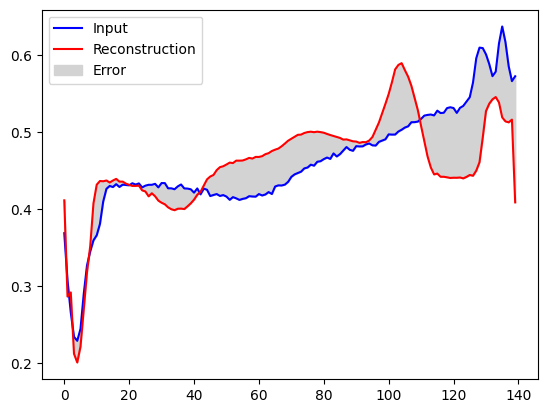

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightgray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

In [ ]:
normal_train_data.shape

TensorShape([2359, 140])

In [ ]:
reconstructions.shape

(2359, 140)

In [ ]:
train_loss.shape

TensorShape([2359])

74/74 [==============================] - 0s 2ms/step


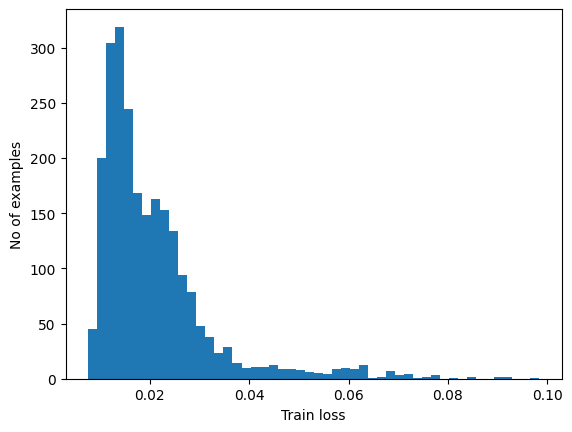

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
np.mean(train_loss)

0.020793037

In [ ]:
np.std(train_loss)

0.011699395

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032492433


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.

14/14 [==============================] - 0s 3ms/step


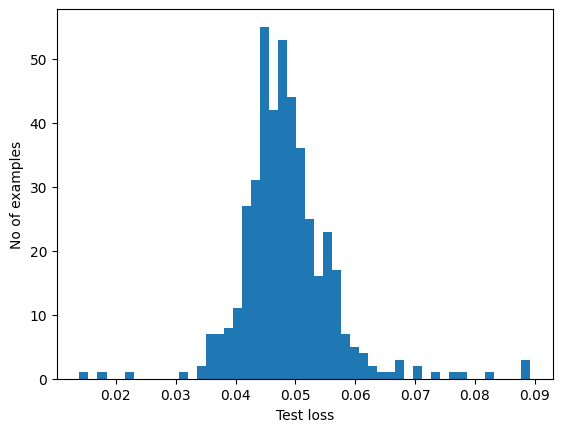

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
